# Phonon Dispersion
## Introduction
- In this example, we use harmonic lattice dynamics to calculate the phonon dispersion of diamond silicon.

### Importing Relevant Functions
- The inputs/outputs for GPUMD are processed using the [Atomic Simulation Environment (ASE)](https://wiki.fysik.dtu.dk/ase/) and the [thermo](https://github.com/AlexGabourie/thermo) package.

In [1]:
from pylab import *
from ase.lattice.cubic import Diamond
from ase.build import bulk
from ase.io import write
from thermo.gpumd.preproc import add_basis, repeat
from thermo.gpumd.io import create_basis, create_kpoints
from thermo.gpumd.data import load_omega2

## Preparting the Inputs
- The structure as specified is 64-atom diamond silicon at zero temperature and zero pressure. 
- Weuse the minimal Tersoff potential [[Fan 2020]](https://doi.org/10.1088/1361-648X/ab5c5f).

### Generate the  [model.xyz](https://gpumd.zheyongfan.org/index.php/The_model.xyz_input_file) file:

### Create Si Unit Cell & Add Basis

In [5]:
a=5.434
Si_UC = bulk('Si', 'diamond', a=a)
add_basis(Si_UC)
Si_UC

Atoms(symbols='Si2', pbc=True, cell=[[0.0, 2.717, 2.717], [2.717, 0.0, 2.717], [2.717, 2.717, 0.0]])

### Transform Si to Cubic Supercell

In [6]:
# Create 8 atom diamond structure
Si = repeat(Si_UC, [2,2,1])
Si.set_cell([a, a, a])
Si.wrap()

# Complete full supercell
Si = repeat(Si, [2,2,2])
Si

Atoms(symbols='Si64', pbc=True, cell=[10.868, 10.868, 10.868])

### Write [model.xyz](https://gpumd.zheyongfan.org/index.php/The_model.xyz_input_file) File

In [9]:
write("model.xyz", Si, write_info=False)

### Write [basis.in](https://gpumd.zheyongfan.org/index.php/The_basis.in_input_file) File
- The [basis.in](https://gpumd.zheyongfan.org/index.php/The_basis.in_input_file) file reads:
```
2
0 28
4 28
0
0
0
0
1
1
1
1
...
```
- Here the primitive cell is chosen as the unit cell. There are only two basis atoms in the unit cell, as indicated by the number 2 in the first line.

- The next two lines list the indices (0 and 4) and masses (both are 28 amu) for the two basis atoms.

- The next lines map all the atoms (including the basis atoms) in the super cell to the basis atoms: atoms equivalent to atom 0 have a label 0, and atoms equivalent to atom 1 have a label 1.

**Note:** The [basis.in](https://gpumd.zheyongfan.org/index.php/The_basis.in_input_file) file generated by this Jupyter notebook may look different, but the same concepts apply and the results will be the same.

In [11]:
create_basis(Si)

### Write [kpoints.in](https://gpumd.zheyongfan.org/index.php/The_kpoints.in_input_file) File
- The $k$ vectors are defined in the reciprocal space with respect to the unit cell chosen in the [basis.in](https://gpumd.zheyongfan.org/index.php/The_basis.in_input_file) file.
- We use the $\Gamma-X-K-\Gamma-L$ path, with 400 $k$ points in total.

In [12]:
linear_path, sym_points, labels = create_kpoints(Si_UC, path='GXKGL',npoints=400)

## The <code>run.in</code> file:
The <code>run.in</code> input file is given below:<br>
```
potential       ../../../potentials/tersoff/Si_Fan_2019.txt
compute_phonon  5 0.005 # in units of A
```

- The first line with the [potential](https://gpumd.zheyongfan.org/index.php/The_potential_keyword) keyword states that the potential to be used is specified in the file [Si_Fan_2019.txt](https://github.com/brucefan1983/GPUMD/blob/master/potentials/tersoff/Si_Fan_2019.txt).

- The second line with the [compute_phonon](https://gpumd.zheyongfan.org/index.php/The_compute_phonon_keyword) keyword tells that the force constants will be calculated with a cutoff of 5.0 $\mathring A$ (here the point is that first and second nearest neighbors need to be included) and a displacement of 0.005 $\mathring A$ will be used in the finite-displacement method.

## Results and Discussion

### Figure Properties

In [13]:
aw = 2
fs = 24
font = {'size'   : fs}
matplotlib.rc('font', **font)
matplotlib.rc('axes' , linewidth=aw)

def set_fig_properties(ax_list):
    tl = 8
    tw = 2
    tlm = 4
    
    for ax in ax_list:
        ax.tick_params(which='major', length=tl, width=tw)
        ax.tick_params(which='minor', length=tlm, width=tw)
        ax.tick_params(which='both', axis='both', direction='in', right=True, top=True)

## Plot Phonon Dispersion
- The [omega2.out](https://gpumd.zheyongfan.org/index.php/The_omega2.out_output_file) output file is loaded and processed to create the following figure. The previously defined kpoints are used for the $x$-axis.

In [16]:
nu = load_omega2()

C:\Users\benward\anaconda3\lib\site-packages\thermo-0.3-py3.8.egg\thermo\gpumd\data.py:205: RuntimeWarning: invalid value encountered in sqrt
  data = np.sqrt(data)/(2*np.pi)


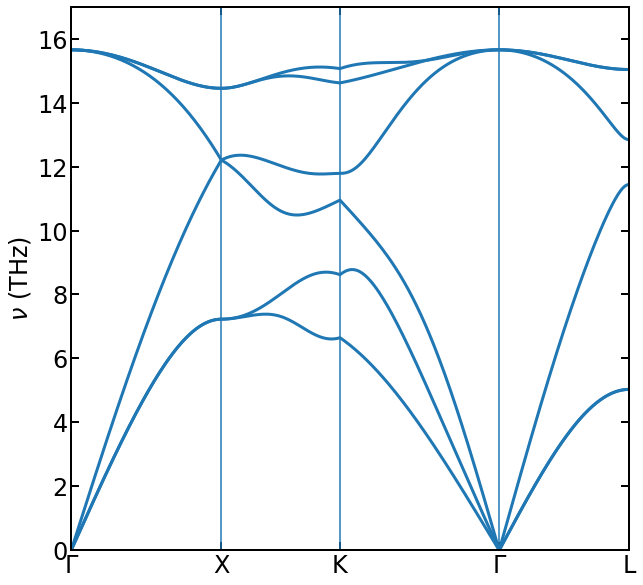

In [17]:
figure(figsize=(10,10))
set_fig_properties([gca()])
vlines(sym_points, ymin=0, ymax=17)
plot(linear_path, nu, color='C0',lw=3)
xlim([0, max(linear_path)])
gca().set_xticks(sym_points)
gca().set_xticklabels([r'$\Gamma$','X', 'K', r'$\Gamma$', 'L'])
ylim([0, 17])
ylabel(r'$\nu$ (THz)')
show()

Phonon dispersion of silicon crystal described by the mini-Tersoff potential.

- The above figure shows the phonon dispersion of silicon crystal described by the mini-Tersoff potential [[Fan 2020]](https://doi.org/10.1088/1361-648X/ab5c5f)

## References
[Fan 2020] Zheyong Fan, Yanzhou Wang, Xiaokun Gu, Ping Qian, Yanjing Su, and Tapio Ala-Nissila, [A minimal Tersoff potential for diamond silicon with improved descriptions of elastic and phonon transport properties](https://doi.org/10.1088/1361-648X/ab5c5f), J. Phys.: Condens. Matter **32** 135901 (2020).